# 8 Copernicus Sentinel-5P TROPOMI - Carbon Monoxide - Level 2

A precursor satellite mission, Sentinel-5P aims to fill in the data gap and provide data continuity between the retirement of the Envisat satellite and NASA's Aura mission and the launch of Sentinel-5. The Copernicus Sentinel-5P mission is being used to closely monitor the changes in air quality and was launched in October 2017.

Sentinel-5P Pre-Ops data are disseminated in the `netCDF` format and can be downloaded via the [Copernicus Open Access Hub](https://scihub.copernicus.eu/).

Sentinel-5P carries the `TROPOMI` instrument, which is a spectrometer in the UV-VIS-NIR-SWIR spectral range. `TROPOMI` provides measurements on:
* `Ozone`
* `NO`<sub>`2`</sub>
* `SO`<sub>`2`</sub>
* `Formaldehyde`
* `Aerosol`
* `Carbonmonoxide`
* `Methane`
* `Clouds`

The subsequent example introduces you to Sentinel-5P data in general and the total column of carbon monoxide sensed by Sentinel-5P TROPOMI in specific. Carbon Monoxide is a good trace gas in order to monitor and track fire occurences.


#### Module outline:
* [1 - Load and browse Sentinel-5P TROPOMI Carbon Monoxide Level 2 data](#load_s5p)
* [2 - Create a geographical subset](#geographical_subset)
* [3 - Visualize Sentinel-5P TROPOMI Carbon Monoxide Level 2 data](#visualize_s5p)

<hr>

#### Load required libraries

In [1]:
import sys
!{sys.executable} -m pip install cartopy netCDF4 h5netcdf==1.3.0 satpy==0.51.0 pyhdf h5py python-geotiepoints

In [2]:
import xarray as xr

import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [3]:
if os.path.exists("functions.ipynb"):
    %run functions.ipynb
elif os.path.exists("../functions.ipynb"):
    %run ../functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/functions.ipynb
    %run functions.ipynb

In [4]:
if os.path.exists("bucket_functions.ipynb"):
    %run bucket_functions.ipynb
elif os.path.exists("../bucket_functions.ipynb"):
    %run ../bucket_functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/90_workshops/202410_wmo_school/bucket_functions.ipynb
    %run bucket_functions.ipynb

In [5]:
base_url = 'https://s3.waw3-2.cloudferro.com/swift/v1/wmo/'
all_paths_list = list_data_on_bucket(base_url)

all_directories_list = [os.path.dirname(path) for path in all_paths_list if path.count('/') <= 4]
# Take unique directories
all_directories_list = list(np.unique(all_directories_list))
all_directories_list

Status ok



[np.str_('eodata'),
 np.str_('eodata/fci'),
 np.str_('eodata/fci/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20240924092245_IDPFI_OPE_20240924092007_20240924092928_N__C_0057_0000'),
 np.str_('eodata/gome2'),
 np.str_('eodata/gome2/aai'),
 np.str_('eodata/gome2/hcho'),
 np.str_('eodata/gome2/hcho/daily'),
 np.str_('eodata/gome2/no2'),
 np.str_('eodata/gome2/no2/daily'),
 np.str_('eodata/iasi'),
 np.str_('eodata/iasi/co'),
 np.str_('eodata/iasi/nh3'),
 np.str_('eodata/meteosat'),
 np.str_('eodata/meteosat/2020'),
 np.str_('eodata/meteosat/2024'),
 np.str_('eodata/modis'),
 np.str_('eodata/modis/10km'),
 np.str_('eodata/modis/level_1b'),
 np.str_('eodata/monarch'),
 np.str_('eodata/pmap'),
 np.str_('eodata/s3'),
 np.str_('eodata/s3/aod'),
 np.str_('eodata/s3/aod/S3A_SL_2_AOD____20240821T082340_20240821T082839_20240821T101507_0299_116_078______MAR_O_NR_003.SEN3'),
 np.str_('eodata/s3/aod/S3A_SL_2_AOD____20240825T081954_20240825T082453_20240825T101112_0299_116_

<hr>

## <a id="load_s5p"></a>Load and browse Sentinel-5P TROPOMI Carbon Monoxide Level 2 data

A Sentinel-5P TROPOMI Carbon Monoxide Level 2 file is organised in two groups: `PRODUCT` and `METADATA`. The `PRODUCT` group stores the main data fields of the product, including `latitude`, `longitude` and the variable itself. The `METADATA` group provides additional metadata items.

Sentinel-5P TROPOMI variables have the following dimensions:
* `scanline`: the number of measurements in the granule / along-track dimension index
* `ground_pixel`: the number of spectra in a measurement / across-track dimension index
* `time`: time reference for the data
* `corner`: pixel corner index
* `layer`: this dimension indicates the vertical grid of profile variables

Sentinel-5P TROPOMI data is disseminated in `netCDF`. You can load multiple `netCDF` files at once with the `open_mfdataset()` function of the xarray library. In order to load the variable as part of a Sentinel-5P data files, you have to specify the following keyword arguments: 
- `group='PRODUCT'`: to load the `PRODUCT` group
- `concat_dim='scanline'`: multiple files will be concatenated based on the scanline dimension
- `combine=nested`: combine n-dimensional grids into one along each dimension of the grid

Let us load a Sentinel-5P TROPOMI data file as `xarray.Dataset` from 21 August 2024 and inspect the data structure:

In [6]:
data_path = base_url+'eodata/s5p/co/S5P_OFFL_L2__CO_____20240821T114951_20240821T133121_35527_03_020600_20240823T014149.nc'
s5p = open_data_from_bucket(data_path, group='PRODUCT')
s5p

File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/s5p/co/S5P_OFFL_L2__CO_____20240821T114951_20240821T133121_35527_03_020600_20240823T014149.nc


<xarray.Dataset> Size: 22MB
Dimensions:                                (time: 1, scanline: 4172,
                                            ground_pixel: 215, corner: 4,
                                            layer: 50)
Coordinates:
  * scanline                               (scanline) float64 33kB 0.0 ... 4....
  * ground_pixel                           (ground_pixel) float64 2kB 0.0 ......
  * time                                   (time) datetime64[ns] 8B 2024-08-21
  * corner                                 (corner) float64 32B 0.0 1.0 2.0 3.0
  * layer                                  (layer) float32 200B 4.95e+04 ... ...
    latitude                               (time, scanline, ground_pixel) float32 4MB ...
    longitude                              (time, scanline, ground_pixel) float32 4MB ...
Data variables:
    delta_time                             (time, scanline) datetime64[ns] 33kB ...
    time_utc                               (time, scanline) object 33kB ...
    qa_value                               (time, scanline, ground_pixel) float32 4MB ...
    carbonmonoxide_total_column            (time, scanline, ground_pixel) float32 4MB ...
    carbonmonoxide_total_column_precision  (time, scanline, ground_pixel) float32 4MB ...
    carbonmonoxide_total_column_corrected  (time, scanline, ground_pixel) float32 4MB ...

You see that the loaded data object contains of five dimensions and five data variables:
* **Dimensions**:
  * `scanline` 
  * `ground_pixel`
  * `time`
  * `corner`
  * `layer`


* **Data variables**:
  * `delta_time`: the offset of individual measurements within the granule, given in milliseconds
  * `time_utc`: valid time stamp of the data
  * `ga_value`: quality descriptor, varying between 0 (nodata) and 1 (full quality data).
  * `carbonmonoxide_total_column`: Vertically integrated CO column density
  * `carbonmonoxide_total_column_precision`: Standard error of the vertically integrate CO column

You can specify one variable of interest by putting the name of the variable into square brackets `[]` and get more detailed information about the variable. E.g. `carbonmonoxide_total_column` is the atmosphere mole content of carbon monoxide, has the unit `mol per m-2`, and has three dimensions, `time`, `scanline` and `groundpixel` respectively.

In [7]:
s5p_co = s5p['carbonmonoxide_total_column']
s5p_co

<xarray.DataArray 'carbonmonoxide_total_column' (time: 1, scanline: 4172,
                                                 ground_pixel: 215)> Size: 4MB
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 33kB 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 2kB 0.0 1.0 2.0 ... 212.0 213.0 214.0
  * time          (time) datetime64[ns] 8B 2024-08-21
    latitude      (time, scanline, ground_pixel) float32 4MB ...
    longitude     (time, scanline, ground_pixel) float32 4MB ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

You can do this for the available variables, but also for the dimensions latitude and longitude.

In [8]:
print('Latitude')
print(s5p_co.latitude)

print('Longitude')
print(s5p_co.longitude)

Latitude
<xarray.DataArray 'latitude' (time: 1, scanline: 4172, ground_pixel: 215)> Size: 4MB
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 33kB 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 2kB 0.0 1.0 2.0 ... 212.0 213.0 214.0
  * time          (time) datetime64[ns] 8B 2024-08-21
    latitude      (time, scanline, ground_pixel) float32 4MB ...
    longitude     (time, scanline, ground_pixel) float32 4MB ...
Attributes:
    long_name:      pixel center latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds
Longitude
<xarray.DataArray 'longitude' (time: 1, scanline: 4172, ground_pixel: 215)> Size: 4MB
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 33kB 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 2kB 0.0 1.0 2.0 .

<br>

You can retrieve the array values of the variable with squared brackets: `[:,:,:]`. One single time step can be selected by specifying one value of the time dimension, e.g. `[0,:,:]`.

In [9]:
s5p_co_2912 = s5p_co[0,:,:]
s5p_co_2912

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 4172,
                                                 ground_pixel: 215)> Size: 4MB
[896980 values with dtype=float32]
Coordinates:
  * scanline      (scanline) float64 33kB 0.0 1.0 2.0 ... 4.17e+03 4.171e+03
  * ground_pixel  (ground_pixel) float64 2kB 0.0 1.0 2.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 8B 2024-08-21
    latitude      (scanline, ground_pixel) float32 4MB ...
    longitude     (scanline, ground_pixel) float32 4MB ...
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

The attributes of the `xarray.DataArray` hold the entry `multiplication_factor_to_convert_to_molecules_percm2`, which is a conversion factor that has to be applied to convert the data from `mol per m`<sup>`2`</sup> to `molecules per cm`<sup>`2`</sup>.


In [10]:
conversion_factor = s5p_co_2912.multiplication_factor_to_convert_to_molecules_percm2
conversion_factor

np.float32(6.022141e+19)

Additionally, you can save the attribute `longname`, which you can make use of when visualizing the data.

In [11]:
longname = s5p_co.long_name
longname

'Vertically integrated CO column'

## <a id='geographical_subset'></a>Create  a geographical subset

You can zoom into a region by specifying a `bounding box` of interest. Let us set the extent to south Africa with the following bounding box information:

In [12]:
latmin = -40
latmax = 10
lonmin = 0
lonmax = 40

You can use the function [generate_geographical_subset](../functions.ipynb#generate_geographical_subset) to subset an `xarray.DataArray` based on a given bounding box. `.compute()` is used to avoid errors wind indexing.

In [13]:
s5p_co_subset = generate_geographical_subset(xarray=s5p_co_2912.compute(), 
                                             latmin=latmin, 
                                             latmax=latmax, 
                                             lonmin=lonmin, 
                                             lonmax=lonmax)
s5p_co_subset

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 1148,
                                                 ground_pixel: 215)> Size: 987kB
array([[       nan,        nan,        nan, ...,        nan, 0.04183101,
               nan],
       [       nan,        nan,        nan, ...,        nan, 0.04103822,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], shape=(1148, 215), dtype=float32)
Coordinates:
  * scanline      (scanline) float64 9kB 901.0 902.0 ... 2.047e+03 2.048e+03
  * ground_pixel  (ground_pixel) float64 2kB 0.0 1.0 2.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 8B 2024-08-21
    latitude      (scanline, ground_pixel) float32 987kB -46.08 -46.0 ... 14.68
    longitude     (scanline, ground_pixel) float32 987kB 7.77 8.246 ... 22.39
Attributes:
    units:                                                 mol m-2
    standard_name:                                         atmosphere_mole_co...
    long_name:                                             Vertically integra...
    ancillary_variables:                                   carbonmonoxide_tot...
    multiplication_factor_to_convert_to_molecules_percm2:  6.022141e+19

<br>

## <a id="plotting_s5p"></a>Plotting example - Sentinel-5P TROPOMI Carbon Monoxide Level 2 data

You can plot data arrays of type `numpy` with matplotlib's `pcolormesh` function. In combination with the library [cartopy](https://scitools.org.uk/cartopy/docs/latest/), you can produce high-quality maps. 

In order to make it easier to visualize the Carbon Monoxide values, we apply the conversion factor to the `xarray.DataArray`. This converts the Carbon Monoxide values from *mol per m<sup>2</sup>* to *molecules per cm<sup>2</sup>*.

In [14]:
s5p_co_converted = s5p_co_subset*conversion_factor
s5p_co_converted

<xarray.DataArray 'carbonmonoxide_total_column' (scanline: 1148,
                                                 ground_pixel: 215)> Size: 987kB
array([[          nan,           nan,           nan, ...,           nan,
        2.5191222e+18,           nan],
       [          nan,           nan,           nan, ...,           nan,
        2.4713792e+18,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]], shape=(1148, 215), dtype=float32)
Coordinates:
  * scanline      (scanline) float64 9kB 901.0 902.0 ... 2.047e+03 2.048e+03
  * ground_pixel  (ground_pixel) float64 2kB 0.0 1.0 2.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 8B 2024-08-21
    latitude      (scanline, ground_pixel) float32 987kB -46.08 -46.0 ... 14.68
    longitude     (scanline, ground_pixel) float32 987kB 7.77 8.246 ... 22.39

For visualization, you can use the function [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh) to visualize the data. The following keyword arguments have to be defined:
* `data_array`
* `longitude`
* `latitude`
* `projection`
* `color palette`
* `unit`
* `long_name`
* `vmin`, 
* `vmax`
* `extent (lonmin, lonmax, latmin, latmax)`
* `set_global`

Now, let us apply the [visualize_pcolormesh](../functions.ipynb#visualize_pcolormesh) function and visualize the vertically integrated carbon monoxide column sensored from the Sentinel-5P satellite on 29 December 2019.

Note: Multiplying the DataArray values with 1e<sup>-18</sup> improves the readibility of the map legend.

(<Figure size 2000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'Vertically integrated CO column'}>)

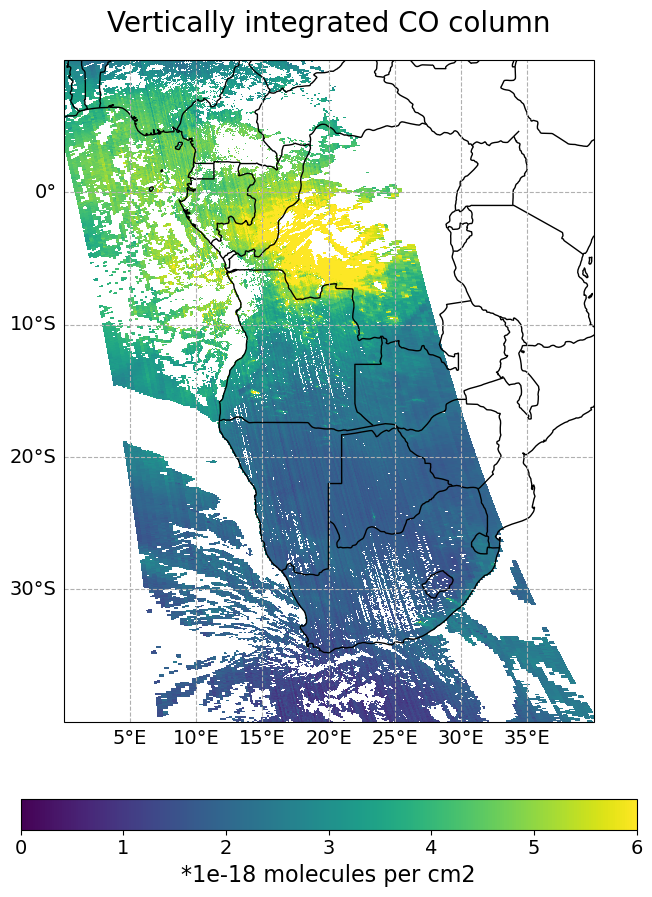

In [15]:
visualize_pcolormesh(data_array=s5p_co_converted*1e-18, 
                     longitude=s5p_co_converted.longitude, 
                     latitude=s5p_co_converted.latitude, 
                     projection=ccrs.PlateCarree(), 
                     color_scale='viridis', 
                     unit='*1e-18 molecules per cm2', 
                     long_name=longname, 
                     vmin=0, 
                     vmax=6, 
                     lonmin=lonmin, 
                     lonmax=lonmax, 
                     latmin=latmin, 
                     latmax=latmax, 
                     set_global=False)


<br>

<hr>

### Resources
This notebook was adapted from: https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/241_Sentinel-5P_TROPOMI_CO_L2_load_browse.ipynb?ref_type=heads

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>